# User-User content based filtering experiments
## By Carter Andrew
### 7/22/23
Source: https://medium.com/grabngoinfo/recommendation-system-user-based-collaborative-filtering-a2e76e3e15c4

### Imports

In [31]:
import pandas as pd
import numpy as np
import scipy as sp

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics.pairwise import cosine_similarity

import sys

### Data

In [32]:
student_data = pd.read_excel("dataset/StudentInformationTable.xlsx")
course_data = pd.read_excel("dataset/CourseInformationTable.xlsx")
career_data = pd.read_excel("dataset/CourseSelectionTable.xlsx")

In [33]:
display(student_data.describe())
display(student_data.head(5))

,StudentId,EnrollmentYear
count,4568.000000,4568.000000
mean,2284.500000,2018.295972
std,1318.812344,1.191886
min,1.000000,2000.000000
25%,1142.750000,2018.000000
50%,2284.500000,2019.000000
75%,3426.250000,2019.000000
max,4568.000000,2020.000000


,StudentId,EnrollmentYear,Education,Major
0,1115,2018,Undergraduate,Biological Science
1,1108,2018,Undergraduate,Biological Science
2,1192,2018,Undergraduate,Urban and Rural Planning
3,1193,2018,Undergraduate,Urban and Rural Planning
4,1293,2018,Undergraduate,World History


In [34]:
display(course_data.describe())
display(course_data.head(5))

,CourseId,Grade
count,5591.000000,5225.000000
mean,2796.000000,2.436842
std,1614.127009,0.939362
min,1.000000,0.000000
25%,1398.500000,2.000000
50%,2796.000000,2.000000
75%,4193.500000,3.000000
max,5591.000000,12.000000


,CourseId,CourseName,College,Type,Grade,Prerequisite,Introduction
0,362,Fascinating Robot,College of Engineering,Whole school optional,2.0,NaN,This course is open to all students in the sch...
1,1045,Introduction to Seismology,School of Earth and Space Sciences,General elective course,2.0,NaN,This course is a quality education general cou...
2,1647,Speeches and oral cultures in China,Department of Chinese Language and Literature,Whole school optional,2.0,NaN,The course is based on the introduction and re...
3,1830,Modern Chinese History,Department of History,Required major,4.0,ancient Chinese history,This course is based on a large number of orig...
4,1834,Chinese Historiography,Department of History,optional,3.0,NaN,This course is a compulsory course for undergr...


In [35]:
display(career_data.describe())
display(career_data.head(5))

,StudentId,Semester,CourseId,Score
count,208949.000000,208941.000000,208949.000000,149223.000000
mean,1878.772590,1.505344,2578.111147,81.154792
std,1245.936537,0.532999,1732.925391,13.841620
min,1.000000,1.000000,1.000000,0.000000
25%,778.000000,1.000000,750.000000,78.000000
50%,1695.000000,1.000000,2569.000000,84.000000
75%,2914.000000,2.000000,4151.000000,90.000000
max,4568.000000,3.000000,5591.000000,100.000000


,StudentId,AcademicYear,Semester,CourseId,CourseName,CourseCollege,Score
0,1115,18-19,1.0,146,Advanced Mathematics (B) (1),National School of Development,81.0
1,1115,18-19,1.0,148,Problem-solving on Higher Mathematics (B),School of Economics,NaN
2,1115,18-19,1.0,654,General Chemistry Practice,College of Engineering,NaN
3,1115,18-19,1.0,681,General Chemistry (B),Department of Medicine Teaching office,72.0
4,1115,18-19,1.0,684,General Chemistry Lab.（B）,Department of Medicine Teaching office,83.5


Note: We think the missing grades are pass/fail classes but this is speculation

### Data cleaning/merging

In [36]:
career_data_clean = career_data.dropna()

In [37]:
print("Number of students in data:  ", career_data_clean.StudentId.nunique())
print("Range of scores:             ", career_data_clean.Score.min(), career_data_clean.Score.max())
print("Unique scores in dataset:    ")
print(np.array(sorted(career_data_clean.Score.unique())))

Number of students in data:   4546
Range of scores:              0.0 100.0
Unique scores in dataset:    
[  0.    1.    1.5   2.    2.5   3.    3.5   4.    5.    5.5   6.    7.
   7.5   8.    9.    9.5  10.   11.   12.   12.5  13.   14.   14.5  15.
  16.   16.5  17.   18.   19.   19.5  20.   20.5  21.   22.   22.5  23.
  23.5  23.6  24.   25.   25.5  26.   27.   27.5  28.   28.5  29.   30.
  30.5  31.   32.   33.   34.   34.5  35.   35.5  36.   36.5  37.   37.5
  38.   38.5  39.   39.5  40.   40.5  41.   41.5  42.   42.5  43.   43.5
  44.   44.5  45.   45.5  46.   46.5  47.   47.5  48.   48.5  49.   49.5
  50.   50.5  51.   51.5  52.   52.5  53.   53.5  54.   54.5  55.   55.5
  56.   56.5  57.   57.5  58.   59.   59.5  60.   60.5  61.   61.5  62.
  62.5  63.   63.5  64.   64.5  65.   65.5  66.   66.5  66.6  67.   67.5
  68.   68.5  69.   69.5  70.   70.5  70.7  71.   71.5  72.   72.5  73.
  73.5  74.   74.5  75.   75.5  76.   76.5  77.   77.5  78.   78.5  79.
  79.5  80.   80.5  80.8  

In [38]:
career_student_data = pd.merge(career_data_clean, student_data, 'inner', 'StudentId')

In [39]:
display(career_student_data.describe())
display(career_student_data.head(5))

,StudentId,Semester,CourseId,Score,EnrollmentYear
count,149021.000000,149021.000000,149021.000000,149021.000000,149021.000000
mean,1631.926044,1.430362,2723.731306,81.136139,2017.849874
std,1163.655105,0.527811,1690.240923,13.840801,1.213044
min,1.000000,1.000000,2.000000,0.000000,2000.000000
25%,617.000000,1.000000,1103.000000,78.000000,2017.000000
50%,1411.000000,1.000000,2740.000000,84.000000,2018.000000
75%,2592.000000,2.000000,4152.000000,90.000000,2019.000000
max,4568.000000,3.000000,5591.000000,100.000000,2020.000000


,StudentId,AcademicYear,Semester,CourseId,CourseName,CourseCollege,Score,EnrollmentYear,Education,Major
0,1115,18-19,1.0,146,Advanced Mathematics (B) (1),National School of Development,81.0,2018,Undergraduate,Biological Science
1,1115,18-19,1.0,681,General Chemistry (B),Department of Medicine Teaching office,72.0,2018,Undergraduate,Biological Science
2,1115,18-19,1.0,684,General Chemistry Lab.（B）,Department of Medicine Teaching office,83.5,2018,Undergraduate,Biological Science
3,1115,18-19,1.0,748,Physiology,College of Life Sciences,85.0,2018,Undergraduate,Biological Science
4,1115,18-19,1.0,844,Physiology Lab.,College of Life Sciences,75.0,2018,Undergraduate,Biological Science


#### Number of classes taken! An important metric
Some students fail out of college, or have only just begun. These datapoints are not very useful for training or reccomending, because there are simply not that many datapoints to reccomend on. Because of this it will probably be useful to only train and reccomend on long lasting student carreers

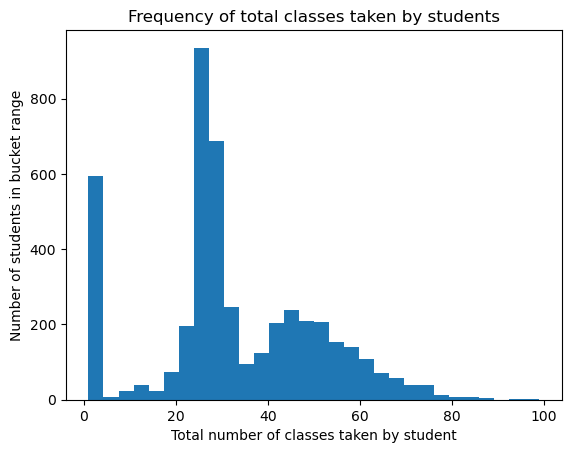

In [40]:
temp_matrix_def_not_jumping_ahead = career_student_data.pivot_table(index="StudentId", columns="CourseId", values="Score")
plt.hist(temp_matrix_def_not_jumping_ahead.count(axis=1), bins=30)
plt.title("Frequency of total classes taken by students")
plt.xlabel("Total number of classes taken by student")
plt.ylabel("Number of students in bucket range")
del(temp_matrix_def_not_jumping_ahead)

As we can see there is a ton of students who take 20-30 classes and call it quits. This is an indicator of a timestamp where students are graduating from programs, anything that extends beyond this is continued education. We can see another cutoff around the 40-50 mark, this might be for a masters program.

### Data partitioning
We should partition data on students, not on individual classes they have taken, so instead of partitioning by selecting random rows we will be selecting random students

In [41]:
all_student_ids = career_student_data.StudentId.unique()
training_students = np.random.choice(all_student_ids, int(all_student_ids.size * .8), False)
testing_students = np.array([i for i in all_student_ids if i not in training_students])
training_data = career_student_data[career_student_data["StudentId"].isin(training_students)]
testing_data = career_student_data[career_student_data["StudentId"].isin(testing_students)]
print("Number of total students:    ", all_student_ids.size)
print("Number of training students: ", training_students.size)
print("Number of testing students:  ", testing_students.size)
display(training_data.describe())
display(testing_data.describe())

Number of total students:     4546
Number of training students:  3636
Number of testing students:   910


,StudentId,Semester,CourseId,Score,EnrollmentYear
count,119823.000000,119823.000000,119823.000000,119823.000000,119823.000000
mean,1618.778891,1.431587,2715.784006,81.079911,2017.839897
std,1162.512326,0.528509,1687.760488,13.936929,1.209059
min,3.000000,1.000000,2.000000,0.000000,2000.000000
25%,606.000000,1.000000,1105.000000,78.000000,2017.000000
50%,1386.000000,1.000000,2734.000000,84.000000,2018.000000
75%,2574.000000,2.000000,4152.000000,90.000000,2019.000000
max,4568.000000,3.000000,5591.000000,100.000000,2020.000000


,StudentId,Semester,CourseId,Score,EnrollmentYear
count,29198.000000,29198.000000,29198.000000,29198.000000,29198.000000
mean,1685.879444,1.425337,2756.345503,81.366888,2017.890814
std,1166.802714,0.524912,1700.022248,13.436884,1.228437
min,1.000000,1.000000,2.000000,0.000000,2000.000000
25%,677.000000,1.000000,1100.000000,78.000000,2017.000000
50%,1516.000000,1.000000,2781.000000,84.000000,2018.000000
75%,2627.000000,2.000000,4153.000000,90.000000,2019.000000
max,4565.000000,3.000000,5591.000000,100.000000,2020.000000


Our means and standard deviations are looking pretty comparable, we could do a t-test to affirm the null hypothesis that our training and testing are 99% probably not statistically different. But I will do this later because we rlly don't need it

### Student-Course Matrix

In [42]:
print("Our training matrix will be a", training_data.StudentId.nunique(), "by", training_data.CourseId.nunique(), "table")
print("Assuming we store a float at each point for the score our table will occupy:", training_data.StudentId.nunique() * training_data.CourseId.nunique() * sys.getsizeof(training_data.Score[0]) /1000000000, "GB")

Our training matrix will be a 3636 by 3516 table
Assuming we store a float at each point for the score our table will occupy: 0.409093632 GB


This is feasable to hold in memory, but definitely a huge table!

In [43]:
training_matrix = training_data.pivot_table(index="StudentId", columns="CourseId", values="Score")
print('Sample courses taken by the first student in our matrix, because the matrix is incredibly sparse\n', training_matrix.iloc[0].dropna())
display(training_matrix.head(5))

Sample courses taken by the first student in our matrix, because the matrix is incredibly sparse
 CourseId
146     70.000000
147     46.166667
167     61.500000
208      0.000000
253     64.000000
          ...    
4189    82.000000
4315    80.000000
4656    66.000000
4657    60.000000
5508    77.000000
Name: 3, Length: 67, dtype: float64


CourseId,2,6,7,9,10,11,15,21,27,28,...,5579,5580,5581,5582,5584,5587,5588,5589,5590,5591
StudentId,,,,,,,,,,,,,,,,,,,,,
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,78.0,NaN,NaN,NaN


#### GPA Time:
Because some students get a higher score than others we need to account for a students GPA so that are final scores are not biased by higher scoring students. To do this we will be normalizing our data by subtracting by the gpa and scaling variance to be on a scale between -1 and 1

In [44]:
train_mat_norm = training_matrix.subtract(training_matrix.mean(axis=1), axis=0)
df_mat_norm = train_mat_norm.divide(train_mat_norm.max(axis=1) * 2, axis=0)
train_mat_norm = train_mat_norm.add(.5)
print('Sample courses taken by the first student in our matrix, because the matrix is incredibly sparse\n', train_mat_norm.iloc[0].dropna())

Sample courses taken by the first student in our matrix, because the matrix is incredibly sparse
 CourseId
146     11.165423
147    -12.667910
167      2.665423
208    -58.834577
253      5.165423
          ...    
4189    23.165423
4315    21.165423
4656     7.165423
4657     1.165423
5508    18.165423
Name: 3, Length: 67, dtype: float64


#### Similarity metrics:
We will be using cosin similarity to get a mearsure of how similar users are

In [45]:
student_similarity = pd.DataFrame(cosine_similarity(train_mat_norm.fillna(0)), index=train_mat_norm.index, columns=train_mat_norm.index)
display(student_similarity.head(5))

StudentId,3,4,5,6,7,8,9,10,11,12,...,4554,4555,4557,4558,4559,4560,4564,4566,4567,4568
StudentId,,,,,,,,,,,,,,,,,,,,,
3,1.000000,0.014461,0.033143,0.069237,0.016068,0.278671,0.006518,0.010902,0.009505,0.050677,...,0.0,0.0,0.0,0.0,0.0,0.0,0.040371,0.037166,0.012732,0.000947
4,0.014461,1.000000,0.082593,0.116415,0.134131,0.042255,0.089257,0.000000,-0.000703,0.074979,...,0.0,0.0,0.0,0.0,0.0,0.0,0.155067,0.163254,0.081586,0.138159
5,0.033143,0.082593,1.000000,0.047073,0.175909,0.078272,0.075224,0.020643,0.020708,0.183708,...,0.0,0.0,0.0,0.0,0.0,0.0,0.115399,0.120937,0.080017,0.099175
6,0.069237,0.116415,0.047073,1.000000,0.237318,0.141835,0.114030,0.000000,0.000117,0.099347,...,0.0,0.0,0.0,0.0,0.0,0.0,0.108987,0.127806,0.083089,0.182840
7,0.016068,0.134131,0.175909,0.237318,1.000000,0.103668,0.170862,0.001616,-0.003546,0.352606,...,0.0,0.0,0.0,0.0,0.0,0.0,0.114450,0.151247,0.121022,0.303799


In [46]:
print('Median user similarity:', student_similarity.median().mean())

Median user similarity: 0.05227341513265532


## Recomendation System
Now that this system is working nicely we can write a couple of functions to calculate our reccomendation, and test our accuracy

First things first, we have a ton of data frames in memory we have no use for, so lets delete them

In [47]:
del_df = [student_data, student_similarity, career_data, career_data_clean, career_student_data, student_similarity, training_matrix]
for df in del_df:
    del(df)

### Testing Functions
Now we need a series of functions that will help us grab a test users, append controlled subsets of their classes, and append those to our data type list. Finally we can check our results by comparing our values to the rest of our data. 

I was considering trying to make the subset of courses selected for the tests to be random, but I don't really think that makes much sense given that there is no real course level number assosiated in the database

In [221]:
class userUserReccomender:
    input_data: pd.DataFrame
    training_data: pd.DataFrame
    testing_data: pd.DataFrame
    student_course_matrix: pd.DataFrame
    matrix_current: bool
    def partitionData(self, proportion_training: float) -> None:
        all_student_ids = self.input_data.StudentId.unique()
        training_students = np.random.choice(all_student_ids, int(all_student_ids.size * proportion_training), False)
        testing_students = np.array([i for i in all_student_ids if i not in training_students])
        self.training_data = self.input_data[self.input_data["StudentId"].isin(training_students)]
        self.testing_data = self.input_data[self.input_data["StudentId"].isin(testing_students)]
        self.matrix_current = False
    def dePartitionData(self) -> None:
        self.training_data = self.input_data
        self.testing_data = pd.DataFrame()
        self.matrix_current = False
    def preProcessData(self) -> None:
        #We only want data with large enough class counts to support a nuanced reccomendation. 
        self.dePartitionData()
        self.updateMatrix()
        dropIds = self.student_course_matrix[self.student_course_matrix.count(axis=1) < 22].index
        self.input_data = self.input_data.drop(self.input_data[self.input_data.StudentId.isin(dropIds)].index)
        self.dePartitionData()
        self.updateMatrix()
    def __init__(self, input_data: pd.DataFrame) -> None:
        self.input_data = input_data
        self.preProcessData()
        self.matrix_current = True
    def updateMatrix(self) -> None:
        self.student_course_matrix = self.training_data.pivot_table(index='StudentId', columns='CourseId', values='Score')
        self.matrix_current = True
    def calculateSingleReccomendation(self, student_id: int, proportion_classes_taken: float) -> tuple[pd.Series, pd.Series, pd.Series]:
        if not self.matrix_current: self.updateMatrix()
        #Make sample matrix to calculate our reccomendation from
        full_carreer = self.student_course_matrix.loc[student_id].copy(deep=True)
        drop_courses = full_carreer.dropna().sample(int(full_carreer.count() * (1-proportion_classes_taken)))
        sample_carreer = full_carreer.copy(deep=True)
        sample_carreer.loc[drop_courses.index.tolist()] = np.nan
        temp_matrix = self.student_course_matrix.copy(deep=True)
        temp_matrix.loc[student_id] = sample_carreer # type: ignore
        #Normalize data
        #temp_matrix = temp_matrix.subtract(temp_matrix.mean(axis=1), axis=0)
        #sample_carreer = sample_carreer.subtract(full_carreer.mean())
        #drop_courses = drop_courses.subtract(full_carreer.mean())
        #Identify similar users
        similar_students = pd.DataFrame(cosine_similarity(temp_matrix[sample_carreer.dropna().index].fillna(0)), index=temp_matrix.index, columns=temp_matrix.index).drop(student_id)[student_id].sort_values(ascending=False)[:1]
        taken_courses = temp_matrix[temp_matrix.index == student_id].dropna(axis=1, how='all')
        reccomended_courses = temp_matrix[temp_matrix.index.isin(similar_students.index)].dropna(axis=1, how='all')
        reccomended_courses.drop(taken_courses.columns,axis=1, inplace=True, errors='ignore')
        reccomendations = {}
        for course in reccomended_courses.columns:
            course_scores = reccomended_courses[course]
            course_score, course_count = 0,0
            for student in similar_students.index:
                if pd.isna(course_scores[student]): continue
                course_score += course_scores[student] * similar_students[student]
                course_count += similar_students[student]
            reccomendations[course] = course_score/course_count
        reccomendations = pd.Series(reccomendations, index=reccomendations.keys()).sort_values(ascending=False) # type: ignore
        return(sample_carreer, drop_courses, reccomendations)
    def calculateMultipleReccomendations(self, student_ids: list[int], proportion_classes_taken: float) -> tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
        if not self.matrix_current: self.updateMatrix()
        full_carreers = self.student_course_matrix.loc[student_ids]
        sample_carreers = full_carreers.copy(deep=True)
        drop_courses = full_carreers.copy()
        for i, student in full_carreers.iterrows():
            drop_course = (student.dropna().sample(int(student.dropna().count() * (1-proportion_classes_taken))))
            drop_courses.loc[i, ~drop_courses.columns.isin(drop_course.index)] = np.nan # type: ignore
            sample_carreers.loc[i,drop_course.index] = np.nan # type: ignore
        temp_matrix = self.student_course_matrix.copy(deep=True)
        temp_matrix.loc[sample_carreers.index.tolist()] = sample_carreers
        reccomendations = pd.DataFrame(index=student_ids, columns=temp_matrix.columns)
        for student_id in student_ids:
            student_similarity = pd.DataFrame(cosine_similarity(temp_matrix[sample_carreers.loc[student_id].dropna().index].fillna(0)), index=temp_matrix.index, columns=temp_matrix.index)
            student_similarity.drop(student_ids, inplace=True)
            simiar_students = student_similarity[student_id].sort_values(ascending=False)[:10] # type: ignore
            taken_courses = temp_matrix.loc[student_id].dropna()
            reccomended_courses = temp_matrix.loc[simiar_students.index].dropna(axis=1, how='all')
            reccomended_courses.drop(taken_courses.index, axis=1, inplace=True, errors='ignore')
            reccomendation = {}
            for course in reccomended_courses.columns:
                course_scores = reccomended_courses[course]
                course_score, course_count = 0,0
                for student in simiar_students.index:
                    if pd.isna(course_scores[student]): continue
                    course_score += course_scores[student] * simiar_students[student]
                    course_count += simiar_students[student]
                reccomendation[course] = course_score/course_count
            reccomendations.loc[student_id, reccomendation.keys()] = reccomendation# type: ignore
        return (sample_carreers, drop_courses, reccomendations)

In [222]:
user_reccomender = userUserReccomender(input_data=career_student_data)

In [223]:
input_courses, output_courses, reccomendation = user_reccomender.calculateSingleReccomendation(4, .5)

In [224]:
print("Courses used for input for student 4:", input_courses.dropna().index)
print("Courses we actaully reccomend:", reccomendation.dropna().sort_values(ascending=False).index)
print("Courses the student actually took, excluding ones used for input:", output_courses.index)
print("Reccomended and taken courses that actually overlap:", reccomendation[reccomendation.index.isin(output_courses.index)].index)
intersection = len(list(set(reccomendation.index).intersection(output_courses.index)))
union = len(reccomendation.index) + len(output_courses.index) - intersection
print("Jaccard similarity:", intersection/union)
reccomendation, output_courses = reccomendation.align(output_courses)
reccomendation, output_courses = reccomendation.fillna(0), output_courses.fillna(0)
cossim = np.dot(reccomendation, output_courses)/(np.linalg.norm(reccomendation) * np.linalg.norm(output_courses))
print("Cosine Similarity:", cossim)

Courses used for input for student 4: Int64Index([ 147,  525,  625,  753,  971,  974,  975,  983,  984, 1074, 1075,
            1078, 1079, 1081, 1082, 1083, 1084, 1085, 1087, 1091, 1092, 1093,
            1104, 1373, 2309, 3811, 3842, 3843, 4121, 4160, 4357, 4656, 4657,
            5508],
           dtype='int64', name='CourseId')
Courses we actaully reccomend: Int64Index([4153, 4163, 4166, 1064, 2827, 1088, 4123, 1068, 3857, 1072, 4116,
            4118, 1254, 4151, 4124, 3324, 1100, 1097,  972, 1073, 1080, 1656,
            1076, 4682, 3839, 1086, 1142,  978, 2323, 1069, 1070, 4310, 1096,
            1025, 3858, 3864, 1071, 1116,  977,  208,  512,  146, 1094,  167,
            4767],
           dtype='int64')
Courses the student actually took, excluding ones used for input: Int64Index([ 208,  167, 1089, 1656,  512, 5458,  970, 1077,  972,  624, 1846,
            2198, 1073,  973, 4159, 4157, 1068, 4118, 1069, 3812,  521, 1080,
             526, 1142, 3810, 4124, 4116,  146, 1086, 41

In [225]:
display(reccomendation[reccomendation==0].count())
display(reccomendation.count())

15

59

In [226]:
input_courses, output_courses, reccomendations = user_reccomender.calculateMultipleReccomendations(user_reccomender.training_data.StudentId.sample(50, replace=True).tolist(), .5)

StudentId
309     0.818312
736     0.765789
308     0.762773
730     0.756135
306     0.745213
52      0.743034
1626    0.738540
733     0.737786
732     0.737644
307     0.733418
Name: 737, dtype: float64
StudentId
340    0.910037
343    0.862503
342    0.776536
770    0.749723
344    0.682949
513    0.667103
223    0.640928
180    0.634961
243    0.634027
260    0.633647
Name: 341, dtype: float64
StudentId
1227    0.906344
785     0.899070
372     0.892653
1210    0.886483
1217    0.879674
1223    0.877634
1219    0.875456
787     0.873374
538     0.873033
1697    0.872648
Name: 1766, dtype: float64
StudentId
2530    0.898846
2489    0.896846
1123    0.894767
2536    0.872226
2549    0.869089
2594    0.857043
2495    0.856146
2509    0.856048
2523    0.855608
2552    0.855533
Name: 2550, dtype: float64
StudentId
946     0.894340
424     0.860278
612     0.860182
101     0.859177
106     0.859037
959     0.857589
931     0.857102
963     0.856873
1126    0.856671
976     0.856200
Name

ValueError: Found array with 0 feature(s) (shape=(3741, 0)) while a minimum of 1 is required by check_pairwise_arrays.

In [ ]:
display(input_courses.head(5), output_courses.head(5), reccomendations.head(5))

CourseId,2,6,7,9,10,11,15,20,21,27,...,5579,5580,5581,5582,5584,5587,5588,5589,5590,5591
StudentId,,,,,,,,,,,,,,,,,,,,,
2917,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2819,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
486,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2565,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3458,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


CourseId,2,6,7,9,10,11,15,20,21,27,...,5579,5580,5581,5582,5584,5587,5588,5589,5590,5591
StudentId,,,,,,,,,,,,,,,,,,,,,
2917,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2819,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
486,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2565,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3458,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


CourseId,2,6,7,9,10,11,15,20,21,27,...,5579,5580,5581,5582,5584,5587,5588,5589,5590,5591
2917,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2819,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
486,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2565,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3458,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
print(cosine_similarity(output_courses.fillna(0), reccomendations.fillna(0)))

[[0.41773049 0.0577391  0.         ... 0.04239982 0.16169755 0.07391426]
 [0.         0.10349138 0.10751592 ... 0.05536565 0.07876069 0.06270441]
 [0.         0.09395544 0.41347295 ... 0.         0.11132472 0.06623678]
 ...
 [0.09401679 0.         0.01569689 ... 0.40738524 0.05684875 0.08191387]
 [0.10867629 0.09529523 0.08268883 ... 0.03928382 0.89290256 0.11272592]
 [0.15258896 0.11266703 0.         ... 0.07896484 0.1460445  0.57613308]]
